In [139]:
# Importing the dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

## Data preprocessing


In [140]:
calories = pd.read_csv('../data/calories.csv')

In [141]:
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [142]:
activities = pd.read_csv('../data/exercise.csv')

In [143]:
activities.shape

(15000, 8)

In [144]:
activities.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [145]:
# Combining the calories and acitivities
f_activities = pd.concat([activities, calories['Calories']], axis=1)

In [146]:
f_activities.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [147]:
# Filtering only female records
female_activities = f_activities.loc[activities['Gender'] == 'female']

In [148]:
female_activities.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0
6,19602372,female,33,158.0,56.0,22.0,95.0,40.5,112.0


In [149]:
female_activities.shape

(7553, 9)

### Creating a dataframe based on the intensity of the activity


In [150]:
female_activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7553 entries, 1 to 14997
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     7553 non-null   int64  
 1   Gender      7553 non-null   object 
 2   Age         7553 non-null   int64  
 3   Height      7553 non-null   float64
 4   Weight      7553 non-null   float64
 5   Duration    7553 non-null   float64
 6   Heart_Rate  7553 non-null   float64
 7   Body_Temp   7553 non-null   float64
 8   Calories    7553 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 590.1+ KB


In [151]:
# list of classified workouts 
'''
    HIIT - High intensity interval training,
    LIIT - Low intensity interval training,
    MIIT - Medium intensity interval training
'''
# create a list of our conditions
def map_activities(rate):
    if rate > 95 and rate <= 105:
        return 'Running or Gym (HIIT)'
    elif rate > 85 and rate <= 95:
        return 'Jogging (MIIT)'
    elif rate > 75 and rate <= 85:
        return 'Walking (LIIT)'
    else:
        return 'Mild acitivity (LIIT)'


female_activities['Activity_Type'] = female_activities['Heart_Rate'].apply(lambda rate: map_activities(rate))

In [152]:
female_activities.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Activity_Type
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,Jogging (MIIT)
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,Running or Gym (HIIT)
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,Walking (LIIT)
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0,Running or Gym (HIIT)
6,19602372,female,33,158.0,56.0,22.0,95.0,40.5,112.0,Jogging (MIIT)


### Data cleaning

In [153]:
# Remove unwanted columns
female_activities.drop('User_ID', inplace=True, axis=1)
female_activities.drop('Gender', inplace=True, axis=1)

In [154]:
# checking missing values
female_activities.isnull().sum()

Age              0
Height           0
Weight           0
Duration         0
Heart_Rate       0
Body_Temp        0
Calories         0
Activity_Type    0
dtype: int64

In [155]:
# Encode the values
'''
    We encode all the columns to make use of numeric values
'''

from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()

# encode the activity type
female_activities['Activity_Type'] = label_encoder.fit_transform(female_activities['Activity_Type'])

In [156]:
'''
    Running or Gym (HIIT) - 2
    Jogging (MIIT) - 0
    Walking (LIIT) - 3
    Mild acitivity (LIIT) - 1
'''
female_activities.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Activity_Type
1,20,166.0,60.0,14.0,94.0,40.3,66.0,0
3,34,179.0,71.0,13.0,100.0,40.5,71.0,2
4,27,154.0,58.0,10.0,81.0,39.8,35.0,3
5,36,151.0,50.0,23.0,96.0,40.7,123.0,2
6,33,158.0,56.0,22.0,95.0,40.5,112.0,0


In [157]:
female_activities['Activity_Type'].unique()

array([0, 2, 3, 1])

In [158]:
female_activities['Activity_Type'].value_counts()

0    2513
2    2499
1    1338
3    1203
Name: Activity_Type, dtype: int64

## Data analysis | EDA

In [159]:
female_activities.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Activity_Type
count,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000
mean,42.735469,164.405931,63.274460,15.502185,95.408579,40.019833,88.153052,1.316695
std,16.939220,10.089177,8.449548,8.352013,9.601109,0.784733,58.586980,1.095691
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,2.000000,0.000000
25%,28.000000,158.000000,57.000000,8.000000,88.000000,39.600000,36.000000,0.000000
50%,40.000000,164.000000,63.000000,16.000000,95.000000,40.200000,80.000000,1.000000
75%,56.000000,171.000000,69.000000,23.000000,103.000000,40.600000,135.000000,2.000000
max,79.000000,205.000000,101.000000,30.000000,122.000000,41.500000,240.000000,3.000000


In [160]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='Activity_Type', ylabel='count'>

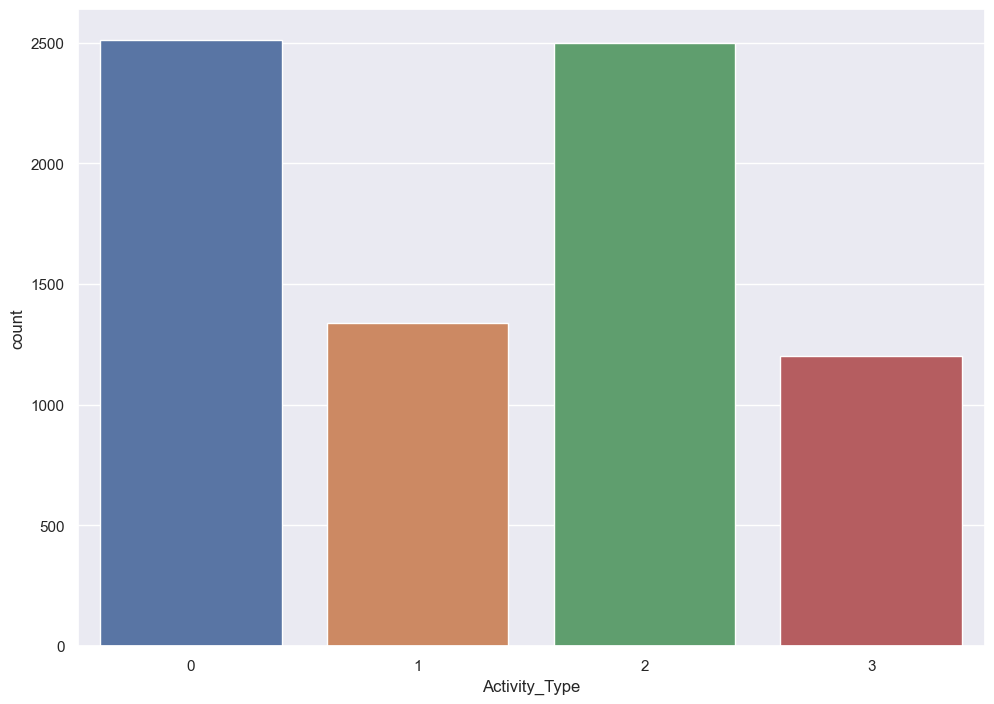

In [161]:
# Visualize Activity type 
sns.countplot(female_activities['Activity_Type'])


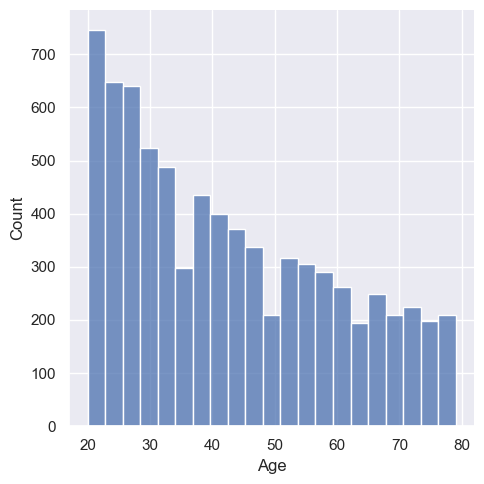

In [162]:
# Distribution plot of age
'''
    Based on the analysis more number of females on the age of 20 - 25 is highly avtive,
    25 - 45 is average and less activities for females who has age > 50
'''
sns.displot(female_activities['Age'])


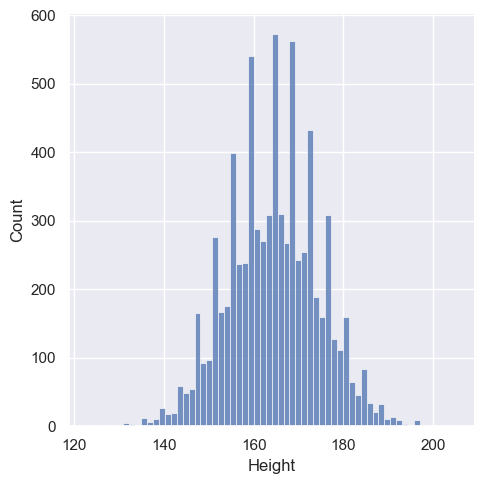

In [163]:
# Distribution plot of height
'''
    Based on the analysis it has a normal distribution where people with average height
    is more interested in workouts and activities
'''
sns.displot(female_activities['Height'])

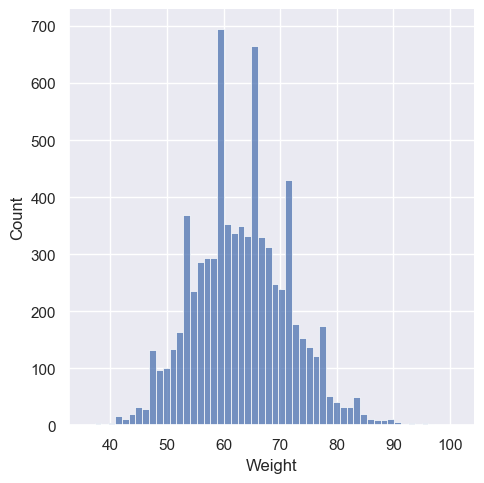

In [164]:
# Distribution plot of height
'''
    Based on the analysis it has a normal distribution where people with average weight > 50 & < 70
    is more interested in workouts and activities
'''
sns.displot(female_activities['Weight'])

<AxesSubplot:>

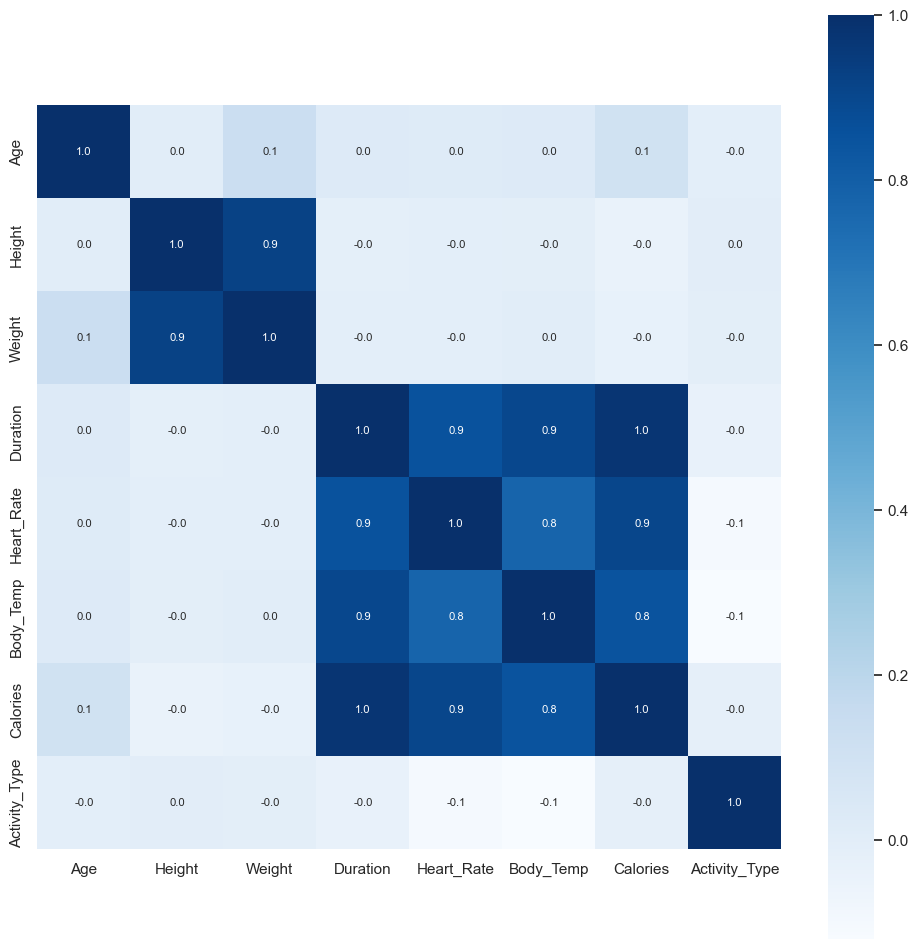

In [165]:
# Positive correlation
# Negative correlation
correlation = female_activities.corr()

plt.figure(figsize=(12,12))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8},cmap='Blues')

### Transforming the data

In [166]:
features = female_activities.drop('Activity_Type', axis=1)
label = female_activities['Activity_Type']
X_train, X_test, Y_train, Y_test = train_test_split(features, label, test_size=0.2, random_state=2)

In [167]:
print(X_train.shape, X_test.shape) # 80% | 20%

(6042, 7) (1511, 7)


In [168]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(female_activities)
scaled_data=scaling.transform(female_activities)

In [169]:
# Set the n_components=3
principal=PCA(n_components=3)
principal.fit(scaled_data)
pca=principal.transform(scaled_data)
 
# Check the dimensions of data after PCA
pca.shape

(7553, 3)

In [171]:
# Check the values of eigen vectors
# prodeced by principal components
principal.components_

array([[-3.18612120e-02,  1.75033589e-02,  1.31966825e-02,
        -5.12532562e-01, -4.85724654e-01, -4.84179843e-01,
        -5.12672858e-01,  5.12122621e-02],
       [ 1.03929280e-01,  6.99478961e-01,  7.06598968e-01,
         1.13704296e-02,  1.01140360e-02,  1.86725029e-02,
        -3.69334038e-03, -7.20441655e-03],
       [ 4.85054154e-01, -6.22483654e-02,  8.13099978e-04,
         3.76868852e-02, -3.06221793e-02, -5.28156687e-02,
         9.52816763e-02,  8.64072240e-01]])

Text(0, 0.5, 'pc2')

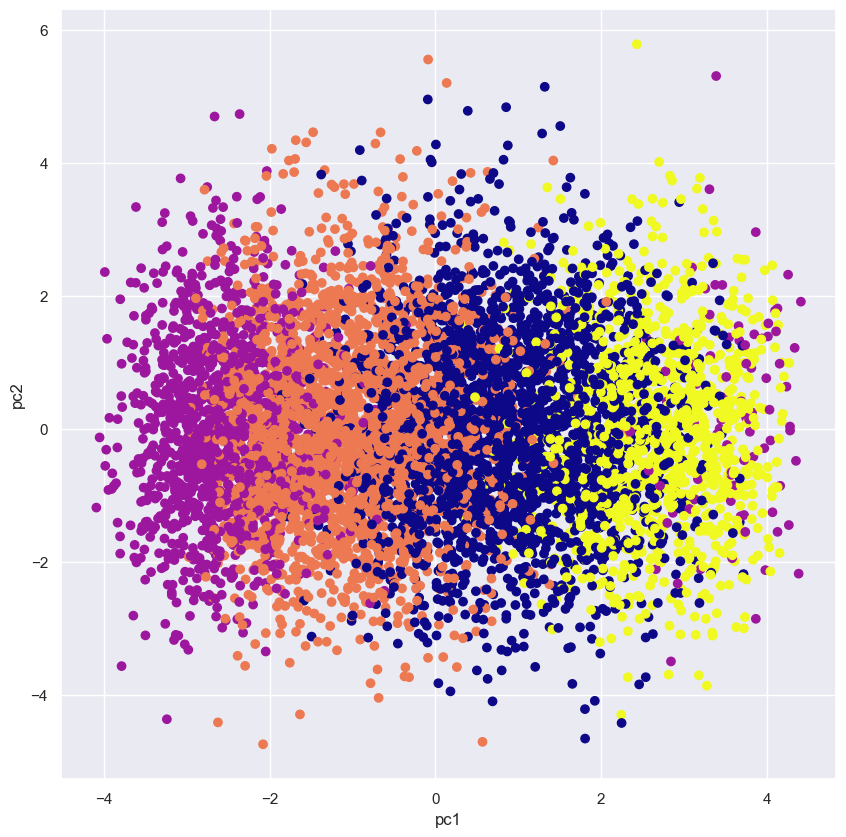

In [172]:

plt.figure(figsize=(10,10))
plt.scatter(pca[:,0],pca[:,1],c=female_activities['Activity_Type'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')